In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import pickle
import pyfftw
from labutil.opticstools import Metadata,propKernel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# DPC example

In [4]:

data_params = Metadata(imgs[0].shape,wavelength=0.514,mag=80.601,NA=0.65,NA_in=0.0,RI=1.5720,rotation=[0,180,90,270])

problem dependent metadata:
NA_in:0.0
rotation:[0, 180, 90, 270]


In [5]:
from dpc import DPCSolver
DPCObj = DPCSolver(data_params,imgs)

(xmin=315, xmax=390, ymin=137, ymax=202)


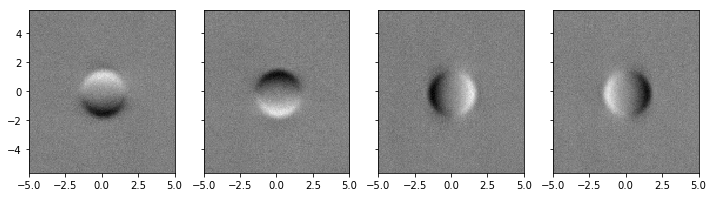

In [6]:
%matplotlib inline
#plot first set of measured DPC intensities
f,ax = plt.subplots(1,4,sharex=True,sharey=True,figsize=(12,3))
for plotIdx in range(4):
    ax[plotIdx].imshow(DPCObj.intensity[plotIdx],cmap='gray',clim=(-.2,.2),\
                       extent=[min(data_params.xlin.real),max(data_params.xlin.real),min(data_params.ylin.real),max(data_params.ylin.real)])
    ax[plotIdx].set_xlim(-5,5)
    ax[plotIdx].set_ylim(-5,5)
    ax[plotIdx].set_aspect(1)

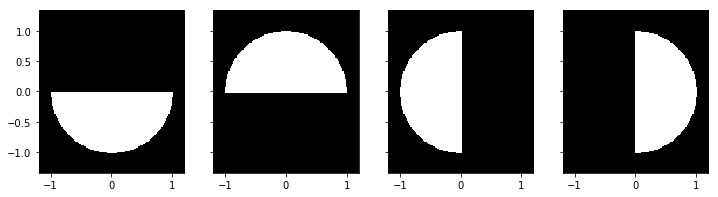

In [7]:
#plot the sources
maxNAx = max(data_params.fxlin.real*data_params.wavelength/data_params.NA)
minNAx = min(data_params.fxlin.real*data_params.wavelength/data_params.NA)
maxNAy = max(data_params.fylin.real*data_params.wavelength/data_params.NA)
minNAy = min(data_params.fylin.real*data_params.wavelength/data_params.NA)
f,ax = plt.subplots(1,4,sharex=True,sharey=True,figsize=(12,3))
for plotIdx,s in enumerate(list(DPCObj.source)):
    ax[plotIdx].imshow(np.fft.fftshift(DPCObj.source[plotIdx]),\
                                            cmap='gray',clim=(0,1),extent=[minNAx,maxNAx,minNAy,maxNAy])
    ax[plotIdx].set_xlim(-1.2,1.2)
    ax[plotIdx].set_ylim(-1.2,1.2)
    ax[plotIdx].set_aspect(1)

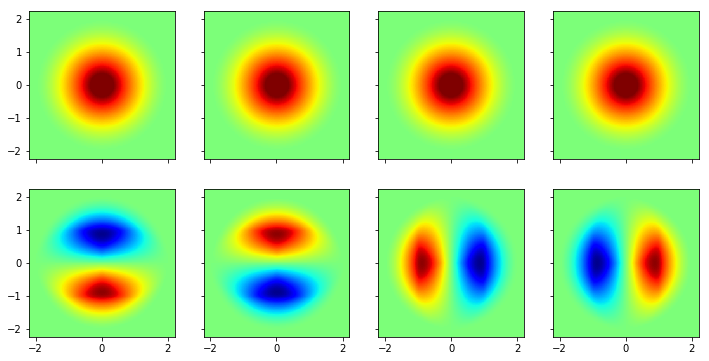

In [8]:

#plot the transfer functions
f,ax = plt.subplots(2,4,sharex=True,sharey=True,figsize = (12,6))
for plotIdx in range(ax.size):
    row = plotIdx//4
    col = np.mod(plotIdx,4)
    if row == 0:
        ax[row,col].imshow(np.fft.fftshift(DPCObj.Hu[col].real),cmap='jet',\
                           extent=[minNAx,maxNAx,minNAy,maxNAy],clim=[-1.6,1.6])
    else:
        ax[row,col].imshow(np.fft.fftshift(DPCObj.Hp[col].imag),cmap='jet',\
                           extent=[minNAx,maxNAx,minNAy,maxNAy],clim=[-.8,.8])
    ax[row,col].set_xlim(-2.2,2.2)
    ax[row,col].set_ylim(-2.2,2.2)
    ax[row,col].set_aspect(1)

In [ ]:
DPCObj.reg_u=1e-1
DPCObj.reg_p=1e-5
dpc_phase_l2 = DPCObj.solve()

In [ ]:
DPCObj.reg_u=1
DPCObj.reg_p=1e-5
DPCObj.reg_TV = (1e-2,1e-2)
DPCObj.rho = 5e-1
dpc_phase_1_iso = DPCObj.solve(method='tvDeconv')

In [ ]:
DPCObj.reg_u=1
DPCObj.reg_p=1e-5
DPCObj.reg_TV = (1e-2,1e-2)
DPCObj.rho = 5e-1
dpc_phase_2_iso = DPCObj.solve(method='tvDeconv',order = 2)

In [ ]:
import contexttimer
with contexttimer.Timer() as t:
    DPCObj.reg_u=1
    DPCObj.reg_p=1e-5
    DPCObj.reg_TV = (1e-2,1e-2)
    DPCObj.rho = 5e-1
    dpc_phase_3_iso = DPCObj.solve(method='tvDeconv',order = 3)
    print(t.elapsed)

In [ ]:
from labutil.opticstools import pupilGen,Fourier
Fobj = Fourier(data_params.dim,(-1,-2))
F = lambda x: Fobj.fourierTransform(x)
IF = lambda x: Fobj.inverseFourierTransform(x)
P2NA = pupilGen(data_params,data_params.NA*2.0)
phantom = np.zeros(data_params.dim)
phantom = (1.5**-1)*(1.5**2-(data_params.xlin.real[np.newaxis,:]-0.1)**2-(data_params.ylin.real[:,np.newaxis]+0)**2)**0.5
phantom[(data_params.xlin.real[np.newaxis,:]-0.1)**2+(data_params.ylin.real[:,np.newaxis]+0)**2>1.5**2]=0
# phantom = np.angle(IF(F(np.exp(1j*phantom))*P2NA))
color_label = ['r','g','b','c']
for plotIdx,img in enumerate([dpc_phase_l2[0],dpc_phase_1_iso[0],dpc_phase_2_iso[0],dpc_phase_3_iso[0]]):
    plt.plot(img[260,:].imag,color=color_label[plotIdx])
    plt.xlim(160,350)
plt.scatter(np.arange(512),phantom[260,:],facecolors='none',edgecolors='k')

In [ ]:
color_label = ['r','g','b','c','k']
for plotIdx,img in enumerate([dpc_phase_l2[0],dpc_phase_1_iso[0],dpc_phase_2_iso[0],dpc_phase_3_iso[0],1j*phantom]):
    plt.plot(np.gradient(img[260,:].imag),color=color_label[plotIdx])
    plt.xlim(160,350)

In [ ]:
color_label = ['r','g','b','c','k']
for plotIdx,img in enumerate([dpc_phase_l2[0],dpc_phase_1_iso[0],dpc_phase_2_iso[0],dpc_phase_3_iso[0],1j*phantom]):
    plt.plot(np.gradient(np.gradient(img[260,:].imag)),color=color_label[plotIdx])
    plt.xlim(160,350)

In [ ]:
color_label = ['r','g','b','c','k']
for plotIdx,img in enumerate([dpc_phase_l2[0],dpc_phase_1_iso[0],dpc_phase_2_iso[0],dpc_phase_3_iso[0],1j*phantom]):
    plt.plot(np.gradient(np.gradient(np.gradient(img[260,:].imag))),color=color_label[plotIdx])
    plt.xlim(160,350)

In [ ]:
plt.figure(figsize=(10,6))
for plotIdx,img in enumerate([dpc_phase_l2,dpc_phase_1_iso,dpc_phase_2_iso,dpc_phase_3_iso,\
                              dpc_phase_l2,dpc_phase_1_iso,dpc_phase_2_iso,dpc_phase_3_iso]):
    plt.subplot('24'+str(plotIdx+1))
    val_limit = (0.95,1.05) if plotIdx<4 else (-.5,1.1)
    data_display = np.exp(img[0].real) if plotIdx<4 else img[0].imag
    plt.imshow(data_display,clim=val_limit,cmap='gray',extent=[min(data_params.xlin.real),max(data_params.xlin.real),min(data_params.ylin.real),max(data_params.ylin.real)])
    if plotIdx>3: plt.xlabel('x, $\mu m$')
    if plotIdx==0 or plotIdx==4:plt.ylabel('y, $\mu m$')
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    title_text = 'amplitude' if plotIdx<4 else 'phase'
    plt.title(title_text)

In [ ]:
plt.figure(figsize=(16,4))
for plotIdx,img in enumerate([dpc_phase_l2,dpc_phase_1_iso,dpc_phase_2_iso,dpc_phase_3_iso,[1j*phantom]]):
    plt.subplot('15'+str(plotIdx+1))
    plt.imshow(np.gradient(img[0].imag,axis=0),clim=(-.1,.1),cmap='gray',extent=[min(data_params.xlin.real),max(data_params.xlin.real),min(data_params.ylin.real),max(data_params.ylin.real)])
    plt.xlabel('x, $\mu m$')
    if plotIdx==0:plt.ylabel('y, $\mu m$')
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    plt.title('phase_gradient')

In [ ]:
dpc_phase_gd,error_gd = DPCObj.solve(method='gradientDescent',maxIter=200,convex=True,plot_verbose=False,verbose=True)

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(dpc_phase_gd[0].imag,cmap='gray',clim=(-0.5,1.1),extent=[min(data_params.xlin.real),max(data_params.xlin.real),min(data_params.ylin.real),max(data_params.ylin.real)])
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.subplot(132)
plt.plot(dpc_phase_gd[0,260,:].imag,color='r')
plt.xlim(160,350)
plt.subplot(133)
plt.scatter(np.arange(len(error_gd[0])),np.log10(error_gd[0]),marker='o',color='b')

In [ ]:
dpc_phase_FISTA,error_FISTA = DPCObj.solve(method='FISTA',maxIter=200,convex=True,plot_verbose=False,verbose=True)

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(dpc_phase_FISTA[0].imag,cmap='gray',clim=(-0.5,1.1),extent=[min(data_params.xlin.real),max(data_params.xlin.real),min(data_params.ylin.real),max(data_params.ylin.real)])
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.subplot(132)
plt.plot(dpc_phase_FISTA[0,260,:].imag,color='r')
plt.xlim(160,350)
plt.subplot(133)
plt.scatter(np.arange(len(error_FISTA[0])),np.log10(error_FISTA[0]),marker='o',color='b')

In [ ]:
dpc_phase_newton,error_newton = DPCObj.solve(method='newton',maxIter=3,verbose=True)

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(dpc_phase_newton[0].imag,cmap='gray',clim=(-0.5,1.1),extent=[min(data_params.xlin.real),max(data_params.xlin.real),min(data_params.ylin.real),max(data_params.ylin.real)])
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.subplot(132)
plt.plot(dpc_phase_newton[0,260,:].imag,color='r')
plt.xlim(160,350)
plt.subplot(133)
plt.scatter(np.arange(len(error_newton[0])),np.log10(error_newton[0]),marker='o',color='b')

In [ ]:
pickle.dump(pyfftw.export_wisdom(),open('../wisdoms/wisdom_gallery.pickle','wb'))